### Binary Classification with FastQML's Hybrid Quantum-Classical Classifier

This demonstration showcases the FastQML library's capabilities in implementing and training hybrid quantum-classical Quantum Machine Learning (QML) models efficiently. In this demo we focus on employing the Hybrid Quantum Classifier incorporating Quantum Variational Classifier (VQClassifier) and classical neural network for binary classification. First  VQClassifier model will be implemented and evaluated. Next it will be presented how easily we can crete hybrid quantum-classical model in FastQML by implementing HybridClassifier class.

FastQML uses JAX as backend for all optimization tasks. It is known for its efficiency in computation that can be particularly beneficial for quantum machine learning tasks. By leveraging Just-in-Time (JIT) compilation and other optimization features of JAX, we anticipate a reduction in training time without compromising the model's performance.

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import flax.linen as nn
from fast_qml.quantum_circuits.feature_maps import AngleEmbedding, AmplitudeEmbedding
from fast_qml.quantum_circuits.variational_forms import TwoLocal
from fast_qml.machine_learning.estimators.vqa import VQClassifier
from fast_qml.machine_learning.estimators.hybrid_qnn import HybridClassifier
from fast_qml.machine_learning.callbacks import EarlyStopping

The breast cancer dataset from sklearn serves as our binary classification task. This dataset, derived from digitized images of fine needle aspirates of breast masses, contains 30 features representing cell nuclei characteristics. The classification task is to categorize these instances as benign or malignant.

We begin by normalizing the data and dividing it into training, validation, and testing sets. This step is crucial for a comprehensive evaluation of the VQClassifier's performance.

In [2]:
# Load the breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape, X_test.shape, X_val.shape)

(455, 30) (57, 30) (57, 30)


In the first step, we will construct the fundamental components of our quantum classifier using FastQML: the feature map and the ansatz. The feature map's role is to encode classical data into a quantum state. For this purpose, we will utilize the AmplitudeEmbedding method from FastQML, which efficiently encodes data into quantum states. Given that a single sample from our dataset contains 30 features, and AmplitudeEmbedding can encode 2^qubits_number of features, we will use 5 qubits. This configuration allows us to encode up to 32 features, with the last two being padded with 0.0 to fit our data structure.

Next, we will set up the ansatz for our quantum classifier. The ansatz, composed of a sequence of quantum gates, is responsible for processing the quantum data. In this demonstration, we will employ the TwoLocal form available in FastQML. The TwoLocal form is a versatile and commonly used ansatz. This choice provides a balance between simplicity and the ability to demonstrate the essential features of quantum data processing in FastQML.

By following these steps, we effectively establish the quantum environment necessary for our classifier, showcasing the ease and flexibility of feature mapping and ansatz configuration in FastQML.

In [3]:
# With 5 qubits we have 2^5=32 features at maximum to be encoded
n_qubits = 5

# Create AmplitudeEmbedding feature map with 0.0 padding
feature_map = AmplitudeEmbedding(
    n_qubits=n_qubits,
    pad_with=0.0
)

# TwoLocal ansatz with default parameters
ansatz = TwoLocal(
    n_qubits=n_qubits,
    controlled_gate='CNOT',
    entanglement='circular',
    skip_last_rotations=False,
    reps=2
)

In [4]:
# Create VQClassifier model with defined ansatz and feature map
q_model = VQClassifier(
    n_qubits=n_qubits,
    feature_map=feature_map,
    ansatz=ansatz,
    classes_num=2
)

To better understand the structure of our quantum circuit, we can visualize it with build-in _draw_circuit()_ method. It can be usefully in debugging and optimizing the quantum circuit design.

In [5]:
q_model.draw_circuit()

0: ─╭|Ψ⟩──RY(-0.07)─╭●──────────╭X──||──RY(0.02)──╭●──────────╭X──||──RY(0.14)──┤  
1: ─├|Ψ⟩──RY(0.01)──╰X─╭●───────│───||──RY(0.10)──╰X─╭●───────│───||──RY(0.23)──┤  
2: ─├|Ψ⟩──RY(-0.14)────╰X─╭●────│───||──RY(0.01)─────╰X─╭●────│───||──RY(-0.06)─┤  
3: ─├|Ψ⟩──RY(-0.05)───────╰X─╭●─│───||──RY(-0.11)───────╰X─╭●─│───||──RY(-0.00)─┤  
4: ─╰|Ψ⟩──RY(0.00)───────────╰X─╰●──||──RY(-0.12)──────────╰X─╰●──||──RY(0.12)──┤  


At this stage, we are ready to train our quantum classifier using FastQML. The training process is designed to optimize the model's parameters based on the training data, while also incorporating validation data to ensure robustness and generalizability. To proceed with training, we will use early stopping mechanism from FastQML to ensure that we do not over-fit to the training data.

In [6]:
early_stopping = EarlyStopping(
    patience=30
)

q_model.fit(
    x_train=X_train,
    y_train=y_train,
    x_val=X_val,
    y_val=y_val,
    num_epochs=500,
    learning_rate=0.1,
    early_stopping=early_stopping
)

Epoch 1/500 - train_loss: 13.64482, val_loss: 3.05971
Epoch 2/500 - train_loss: 3.91391, val_loss: 1.41687
Epoch 3/500 - train_loss: 1.62281, val_loss: 0.81154
Epoch 4/500 - train_loss: 1.12224, val_loss: 0.79233
Epoch 5/500 - train_loss: 0.97187, val_loss: 0.81624
Epoch 6/500 - train_loss: 0.97187, val_loss: 0.80838
Epoch 7/500 - train_loss: 0.97187, val_loss: 0.80257
Epoch 8/500 - train_loss: 0.97187, val_loss: 0.79810
Epoch 9/500 - train_loss: 0.97187, val_loss: 0.79456
Epoch 10/500 - train_loss: 0.97187, val_loss: 0.79168
Epoch 11/500 - train_loss: 0.95193, val_loss: 0.79530
Epoch 12/500 - train_loss: 0.95193, val_loss: 0.79206
Epoch 13/500 - train_loss: 0.95193, val_loss: 0.78929
Epoch 14/500 - train_loss: 0.83215, val_loss: 0.78627
Epoch 15/500 - train_loss: 0.81291, val_loss: 0.78187
Epoch 16/500 - train_loss: 0.74407, val_loss: 0.77531
Epoch 17/500 - train_loss: 0.72655, val_loss: 0.76621
Epoch 18/500 - train_loss: 0.71006, val_loss: 0.75431
Epoch 19/500 - train_loss: 0.69378, 

With the model now trained, our next step is to evaluate its performance on the test data. In order to present the model's performance Scikit-learn _classification_report_ and _ConfusionMatrixDisplay_ methods will be used.

              precision    recall  f1-score   support

           0       0.83      0.62      0.71        16
           1       0.87      0.95      0.91        41

    accuracy                           0.86        57
   macro avg       0.85      0.79      0.81        57
weighted avg       0.86      0.86      0.85        57


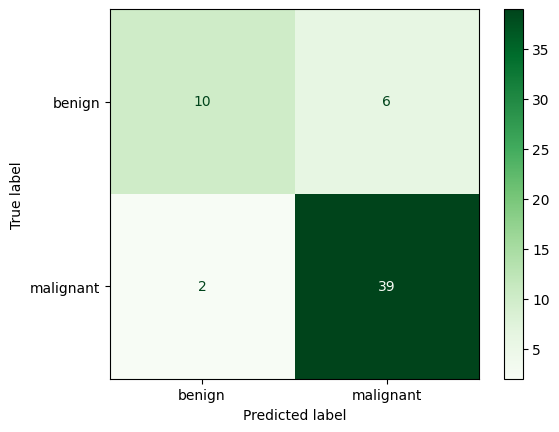

In [7]:
# Make predictions
y_pred = q_model.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malignant'])
disp.plot(cmap='Greens')
plt.show()

With this simple VQClassifier setup we managed to achieve ~86% of accuracy.

Let's try to do better with hybrid quantum-classical model. This approach leverages the unique capabilities of quantum computing for complex problem-solving, while utilizing the robust and scalable nature of classical neural networks. For the classical component, we're employing the Flax library, a powerful tool within JAX for building deep learning models, known for its flexibility and high-performance capabilities in machine learning tasks. In FastQML it is enough to define classical model, quantum model (e.g. VQClassifier class if classification is out objective) and provide them to FastQML's HybridClassifier class.

First let's begin with defining quantum model. We will use the same ansatz, but because classical model will be used for dimensionality reduction, AmplitudeEmbedding will be replaced with AngleEmbedding encoding n_qubits number of features.

In [8]:
# We will use 5 qubits, as we will have 5 outputs from classical model
n_qubits = 5

# This time we will use AngleEmbedding, which can encode n_qubits features
feature_map = AngleEmbedding(
    n_qubits=n_qubits
)

# TwoLocal ansatz
ansatz = TwoLocal(
    n_qubits=n_qubits,
    controlled_gate='CNOT',
    entanglement='circular',
    skip_last_rotations=False,
    reps=1
)

q_model = VQClassifier(
    n_qubits=n_qubits,
    feature_map=feature_map,
    ansatz=ansatz,
    classes_num=2
)

In [9]:
q_model.draw_circuit()

0: ─╭AngleEmbedding(M0)──RY(-0.07)─╭●──────────╭X──||──RY(0.21)──┤  
1: ─├AngleEmbedding(M0)──RY(0.02)──╰X─╭●───────│───||──RY(0.20)──┤  
2: ─├AngleEmbedding(M0)──RY(-0.02)────╰X─╭●────│───||──RY(-0.04)─┤  
3: ─├AngleEmbedding(M0)──RY(-0.08)───────╰X─╭●─│───||──RY(-0.05)─┤  
4: ─╰AngleEmbedding(M0)──RY(-0.03)──────────╰X─╰●──||──RY(0.01)──┤  
M0 = 
[[-0.96555528  0.13569958  0.74156115 -0.21455999  0.37571703]]


Now, let's define our classical neural network using Flax, which offers a user-friendly interface akin to PyTorch. For demonstration, we'll construct a straightforward model comprising just two compact hidden layers, showcasing the simplicity and efficiency of Flax in model development.

In [10]:
class SimpleNN(nn.Module):
    num_hidden1 : int
    num_hidden2 : int
    num_outputs : int

    def setup(self):
        self.linear1 = nn.Dense(features=self.num_hidden1)
        self.linear2 = nn.Dense(features=self.num_hidden2)
        self.linear3 = nn.Dense(features=self.num_outputs)

    def __call__(self, x):
        x = self.linear1(x)
        x = nn.elu(x)
        x = self.linear2(x)
        x = nn.elu(x)
        x = self.linear3(x)
        return x
    
c_model = SimpleNN(
    num_hidden1=30, 
    num_hidden2=16,
    num_outputs=n_qubits
)

We can also print the Flax model to show its attributes.

In [11]:
print(c_model)

SimpleNN(
    # attributes
    num_hidden1 = 30
    num_hidden2 = 16
    num_outputs = 5
)


At last, we arrive at the creation of our hybrid quantum-classical model. This is achieved by seamlessly integrating our pre-defined classical and quantum models into the HybridClassifier class. Once integrated, we simply execute the fit method to commence the training process, effectively harnessing the combined power of both quantum and classical computing paradigms.

In [12]:
model = HybridClassifier(
    input_shape=X_train.shape,
    c_model=c_model,
    q_model=q_model
)

In [13]:
early_stopping = EarlyStopping(
    patience=35
)

model.fit(
    x_train=X_train,
    y_train=y_train,
    x_val=X_val,
    y_val=y_val,
    learning_rate=0.005,
    num_epochs=500,
    early_stopping=early_stopping
)

Epoch 1/500 - train_loss: 0.93056, val_loss: 0.79004
Epoch 2/500 - train_loss: 0.65303, val_loss: 0.59367
Epoch 3/500 - train_loss: 0.52375, val_loss: 0.51523
Epoch 4/500 - train_loss: 0.49343, val_loss: 0.49854
Epoch 5/500 - train_loss: 0.50839, val_loss: 0.49414
Epoch 6/500 - train_loss: 0.52020, val_loss: 0.47983
Epoch 7/500 - train_loss: 0.50948, val_loss: 0.45721
Epoch 8/500 - train_loss: 0.48170, val_loss: 0.43513
Epoch 9/500 - train_loss: 0.44940, val_loss: 0.41967
Epoch 10/500 - train_loss: 0.42163, val_loss: 0.41126
Epoch 11/500 - train_loss: 0.40116, val_loss: 0.40579
Epoch 12/500 - train_loss: 0.38578, val_loss: 0.39675
Epoch 13/500 - train_loss: 0.37083, val_loss: 0.37849
Epoch 14/500 - train_loss: 0.35158, val_loss: 0.34837
Epoch 15/500 - train_loss: 0.32565, val_loss: 0.30779
Epoch 16/500 - train_loss: 0.29536, val_loss: 0.26456
Epoch 17/500 - train_loss: 0.26834, val_loss: 0.23531
Epoch 18/500 - train_loss: 0.25375, val_loss: 0.21656
Epoch 19/500 - train_loss: 0.24696, v

The evaluation of this hybrid model follows the same protocol as any other estimator, ensuring a familiar and straightforward assessment process.

              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       0.95      1.00      0.98        41

    accuracy                           0.96        57
   macro avg       0.98      0.94      0.95        57
weighted avg       0.97      0.96      0.96        57


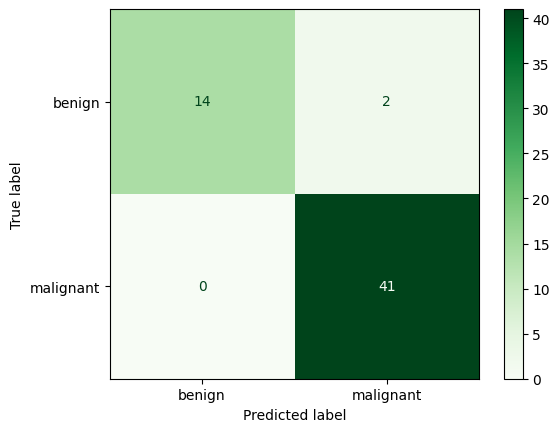

In [14]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malignant'])
disp.plot(cmap='Greens')
plt.show()